# Decison Support System
### Deciding Factors
- Longevity: time since review (Counting no of days since the review was created)
- Length of title and text: count the number of words
- Helpfulness of a review: ratio of “helpful votes” to “total votes”
- Readership: total number of votes of a review (A good estimate that people read it)
- Select products with atleast 100 reviews, eliminated the reviews that had less than 4 votes
- Polarity = positive sentiment + negative sentiment
- Sentiment = (positive sentiment - negative sentiment) - 2
- Initial Data: dataset_electronic.csv converted to text_analysed.txt using sentistrength which is converted to dataset.csv for faster access.

In [3]:
import pandas as pd
import numpy as np
import gzip 
import json
import shutil  #enables us to operate with file objects easily
import time
import math
import matplotlib.pyplot as plt
import pymc3 as pm   #Python package for Bayesian statistical modeling and probabilistic machine learning
import seaborn as sns   #statistical data visualization in python
import re   #regular expression
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency

In [45]:
def getSentimentsAndLengthFromFile(nameOfFile):
    df=pd.DataFrame()
    file = open(nameOfFile, encoding = "utf8")
    count = 0
    column_names = []
    for line in file:
        count=count+1
        if count is 1:
            column_names = line.split('\t')
            df=pd.DataFrame(columns = column_names)
        temp_line = line.rstrip().split('\t')
        df = df.append(pd.Series(temp_line ,index = column_names), ignore_index = True)
    file.close()
    return df

#### Description of the below cell
- the dataset_electronic.csv file is converted to a txt file that is then analysed using the sentistrength software (this is in senti_strength folder), resulting is a .txt file having analysed result
- dataset_analysed.txt contains all the analysed data that is converted to a dataFrame
- dataFrame is stored in a csv file for faster access next time


In [ ]:
data = getSentimentsAndLengthFromFile("datasets/dataset_analysed.txt")

In [2]:
data['polarityText'] = data['reviewTextPositive'] + data['reviewTextNegative']
data['polaritySummary'] = data['summaryPositive'] + data['summaryNegative\n']
data['sentimentText'] = data['reviewTextPositive'] - data['reviewTextNegative']-2
data['sentimentSummary'] = data['summaryPositive'] - data['summaryNegative\n'] - 2
data['summaryLength'] = data['summary'].str.split().str.len()
data['reviewTextLength'] = data['reviewText'].str.split().str.len()
data['readership'] = data['helpful'].str.split(':').str[1]
data['longetivity'] = time.time() - data['unixReviewTime']
del data['no']

In [8]:
data.to_csv("dataset.csv")

In [4]:
# read the dataset
data = pd.read_csv('dataset.csv',index_col=0)

# the column helpful has attributes like helpful votes: total votes
data['helpful_votes'] = data['helpful'].str.split(':').str[0]
data['helpful_votes'] = data.helpful_votes.astype(float)
# print(data['summaryLength']," ",data['summary'])
# print(data['helpful'])
data['longetivity'] = data['longetivity']//86400
# data.head()


In [5]:
# Select products wtih atleast 100 reviews, eliminated the reviews that had less than 4 votes
tempDf = data.groupby('asin').size().rename("countOfReviews").reset_index()
data = data.merge(tempDf)
data = data[data['countOfReviews'] >= 100]   #product must have atleast 100 reviews
data = data.loc[data['readership'] >= 4]     #review must have atleast 4 votes

In [6]:
#displaying information for clarity just like in paper page 6 Table 1
table1Df = pd.DataFrame(columns=['range', 'median', 'mean', 'SD'], 
                        index = ['Rating', 'Longetivity', 'Total Votes', 'Helpful votes', 'Title sentiment',
                                 'Title polarity', 'Review sentiment', 'Review polarity', 'Title length', 'Review length'])

#For each attribute calculate the range, median, mean and Standard deviation 
table1Df.loc['Rating'] = pd.Series({
    'range' : str(data['overall'].min())+'-'+str(data['overall'].max()),
    'median' : data['overall'].median(),
    'mean' : data['overall'].mean(),
    'SD' : data['overall'].std()
})
table1Df.loc['Longetivity'] = pd.Series({
    'range' : str(data['longetivity'].min())+'-'+str(data['longetivity'].max()),
    'median' : data['longetivity'].median(),
    'mean' : data['longetivity'].mean(),
    'SD' : data['longetivity'].std()
})
table1Df.loc['Total Votes'] = pd.Series({
    'range' : str(data['readership'].min())+'-'+str(data['readership'].max()),
    'median' : data['readership'].median(),
    'mean' : data['readership'].mean(),
    'SD' : data['readership'].std()
})
table1Df.loc['Helpful votes'] = pd.Series({
    'range' : str(data['helpful_votes'].min())+'-'+str(data['helpful_votes'].max()),
    'median' : data['helpful_votes'].median(),
    'mean' : data['helpful_votes'].mean(),
    'SD' : data['helpful_votes'].std()
})
table1Df.loc['Title sentiment'] = pd.Series({
    'range' : str(data['sentimentSummary'].min())+'-'+str(data['sentimentSummary'].max()),
    'median' : data['sentimentSummary'].median(),
    'mean' : data['sentimentSummary'].mean(),
    'SD' : data['sentimentSummary'].std()
})
table1Df.loc['Title polarity'] = pd.Series({
    'range' : str(data['polaritySummary'].min())+'-'+str(data['polaritySummary'].max()),
    'median' : data['polaritySummary'].median(),
    'mean' : data['polaritySummary'].mean(),
    'SD' : data['polaritySummary'].std()
})
table1Df.loc['Review sentiment'] = pd.Series({
    'range' : str(data['sentimentText'].min())+'-'+str(data['sentimentText'].max()),
    'median' : data['sentimentText'].median(),
    'mean' : data['sentimentText'].mean(),
    'SD' : data['sentimentText'].std()
})
table1Df.loc['Review polarity'] = pd.Series({
    'range' : str(data['polarityText'].min())+'-'+str(data['polarityText'].max()),
    'median' : data['polarityText'].median(),
    'mean' : data['polarityText'].mean(),
    'SD' : data['polarityText'].std()
})
table1Df.loc['Title length'] = pd.Series({
    'range' : str(data['summaryLength'].min())+'-'+str(data['summaryLength'].max()),
    'median' : data['summaryLength'].median(),
    'mean' : data['summaryLength'].mean(),
    'SD' : data['summaryLength'].std()
})
table1Df.loc['Review length'] = pd.Series({
    'range' : str(data['reviewTextLength'].min())+'-'+str(data['reviewTextLength'].max()),
    'median' : data['reviewTextLength'].median(),
    'mean' : data['reviewTextLength'].mean(),
    'SD' : data['reviewTextLength'].std()
})


In [6]:
data
table1Df


range median      mean       SD
Rating                  1.0-5.0      4   3.75608  1.50318
Longetivity       1710.0-6887.0   4082   4033.06  1169.66
Total Votes              4-1591      7   24.1913  69.5943
Helpful votes        0.0-1556.0      6   20.6897  66.8541
Title sentiment             0-5      1   1.11111   1.0663
Title polarity             -4-4      0  0.578567  1.24204
Review sentiment            0-8      3   3.17094  1.44084
Review polarity            -3-4      0  0.350427  1.15912
Title length               1-23      5    5.1716  2.85392
Review length        9.0-2079.0    121    176.77  178.095

## Formula 1
- log(Total Votes) = B0 + B1 * Title_Sentiment + B2 * TITLE_POSTIVE + B3 * Title_length + B4 * Title_Sentiment * TITLE_POSTIVE + B5 * log(Review_Length) + B6 * log(Longevity)

In [7]:
#Writing the above formula
readerData = pd.DataFrame()
readerData['Title_Sentiment'] = data['sentimentSummary']
readerData['TITLE_POSITIVE'] = data['polaritySummary']

#If the polatity is >0 then its a positive review
readerData.loc[readerData['TITLE_POSITIVE'] > 0,'temp'] = 1
readerData.loc[readerData['TITLE_POSITIVE'] <= 0,'temp'] = 0
readerData['TITLE_POSITIVE'] = readerData['temp']
del readerData['temp']

readerData['Title_Length'] = data['summaryLength']
readerData['B4_mul'] = readerData['Title_Sentiment'] * readerData['TITLE_POSITIVE']
readerData['B5_mul'] = np.log(data['reviewTextLength'])
readerData['B6_mul'] = np.log(data['longetivity'])
readerData['TITLE_POSITIVE'] = data['summaryPositive']
logTotalVotes = np.log10(data['readership'])
# readerData

In [8]:
#The above formula uses linear regression to fit the data  
#we are trying to fit readership with total number of votes
#LinearRegression().fit(data we are given, line we want to fit)
reg_for_reader = LinearRegression().fit(readerData, logTotalVotes)

In [9]:
readerData['logTotalVotes'] = logTotalVotes 

## Formula 2
- (helpful_votes/total_votes)% = B0 + B1 * Review_Sentiment + B2 * REVIEW_NEUTRAL + B3 * log(Review_length) + B4 * Review_Sentiment * REVIEW_NEUTRAL + B5 * log(Longevity)

In [17]:
helpful = pd.DataFrame()
helpful['Review_Sentiment'] = data['sentimentText']
helpful['REVIEW_NEUTRAL'] = data['polarityText']

#If the polarity is 0 then its a neutral review
helpful.loc[helpful['REVIEW_NEUTRAL'] < 0,'temp'] = 1
helpful.loc[helpful['REVIEW_NEUTRAL'] >= 0,'temp'] = 0
helpful['REVIEW_NEUTRAL'] = helpful['temp']
del helpful['temp']

helpful['B3_mul'] = np.log(data['reviewTextLength'])
helpful['B4_mul'] = helpful['Review_Sentiment']*helpful['REVIEW_NEUTRAL']
helpful['B5_mul'] = np.log(data['longetivity'])
numerator = data['helpful'].str.split(':',n=1,expand=True)[0].astype(float)
denominator = data['helpful'].str.split(':',n=1,expand=True)[1].astype(float)
ratio=numerator/denominator

In [18]:
reg_for_helpful = LinearRegression().fit(helpful, ratio)

In [19]:
helpful['ratio'] = ratio

#Printing out the values of the coefficients found by linear regression
print("These are the coefficients for readership[B1 - B6]:\n",reg_for_reader.coef_) #values of B1 to B6
print("This are the coefficients for helpfulness[B1 - B5]:\n",reg_for_helpful.coef_)  #vales of B1 to B5

These are the coefficients for readership[B1 - B6]:
 [-0.01047036 -0.07413579  0.0048672   0.04432912  0.09628507  0.42113113]
This are the coefficients for helpfulness[B1 - B5]:
 [-0.00761963 -0.16719794  0.09710631  0.02298831  0.18768867]


### Summary of Hypothesis testing

In [13]:
table2Df = pd.DataFrame(columns=['Hypothesized relationship', 'Estimates (Wald Chi-square)', 'Results'], 
                        index = ['H1','H2','H3','H4','H5','H6','H7','H8'])

#dof = degree of feedom, if p>=b then keep the old hypothesis, p=P(value of chi2 >=chi2_found)
obs = np.array([data['longetivity'], data['readership']])
chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H1'] = pd.Series({
    'Hypothesized relationship' : 'Longevity → readership',
    'Estimates (Wald Chi-square)': str(reg_for_reader.coef_[5]) +'(' + str(chi2) + ')',
    'Results':'Supported'
})

obs = np.array([data['sentimentSummary'], data['readership']])
chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H2'] = pd.Series({
    'Hypothesized relationship' : 'Title sentiment → readership',
    'Estimates (Wald Chi-square)': str(reg_for_reader.coef_[0]) +'(' + str(chi2) + ')',
    'Results':'Not Supported'
})

obs = np.array([readerData['B4_mul'], data['readership']])
chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H3'] = pd.Series({
    'Hypothesized relationship' : 'Title sentiment × title positive → readership',
    'Estimates (Wald Chi-square)': str(reg_for_reader.coef_[3]) +'(' + str(chi2) + ')',
    'Results':'Supported'
})

obs = np.array([data['summaryLength'], data['readership']])
chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H4'] = pd.Series({
    'Hypothesized relationship' : 'Title length → readership',
    'Estimates (Wald Chi-square)': str(reg_for_reader.coef_[2]) +'(' + str(chi2) + ')',
    'Results':'Supported'
})

obs = np.array([data['reviewTextLength'], data['readership']])
chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H5'] = pd.Series({
    'Hypothesized relationship' : 'Review length → readership',
    'Estimates (Wald Chi-square)': str(reg_for_reader.coef_[4]) +'(' + str(chi2) + ')',
    'Results':'Supported'
})

obs = np.array([data['reviewTextLength'], ratio])
chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H6'] = pd.Series({
    'Hypothesized relationship' : 'Review length → helpfulness',
    'Estimates (Wald Chi-square)': str(reg_for_helpful.coef_[2]) +'(' + str(chi2) + ')',
    'Results':'Supported'
})

obs = np.array([data['sentimentText'], ratio])
# chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H7'] = pd.Series({
    'Hypothesized relationship' : 'Review sentiment → helpfulness',
    'Estimates (Wald Chi-square)': str(reg_for_helpful.coef_[0]) +'(' + str(chi2) + ')',
    'Results':'Supported'
})

obs = np.array([helpful['B4_mul'], ratio])
# chi2, p, dof, expected = chi2_contingency(obs)
table2Df.loc['H8'] = pd.Series({
    'Hypothesized relationship' : 'Review sentiment × review neutral → helpfulness',
    'Estimates (Wald Chi-square)': str(reg_for_helpful.coef_[3]) +'(' + str(chi2) + ')',
    'Results':'Not Supported'
})


table2Df

Hypothesized relationship  \
H1                           Longevity → readership   
H2                     Title sentiment → readership   
H3    Title sentiment × title positive → readership   
H4                        Title length → readership   
H5                       Review length → readership   
H6                      Review length → helpfulness   
H7                   Review sentiment → helpfulness   
H8  Review sentiment × review neutral → helpfulness   

                  Estimates (Wald Chi-square)        Results  
H1      0.4211311319315973(223815.3744602637)      Supported  
H2   -0.010470360971566506(6685.274522871434)  Not Supported  
H3    0.044329115885705477(6894.838509864072)      Supported  
H4   0.004867197057274029(11880.108455434216)      Supported  
H5     0.09628507394913079(83975.97214680901)      Supported  
H6    0.10071268078797374(1320.9829035426203)      Supported  
H7  0.0007633629153438324(1320.9829035426203)      Supported  
H8  -0.012189419357290072(1320.9829035426203)  Not Supported

In [20]:
data.head()

reviewerID        asin  \
22    AVRFGGCCCR6QU  0972683275   
26   A26QCCO0101CO1  0972683275   
56   A3QH8VQDE7HZCR  0972683275   
82   A38FGQVJM18OWV  0972683275   
141   A7R4R9THNELTP  0972683275   

                                          reviewerName helpful  \
22   "Alberto Dieguez ""premiere purchaser of rando...     3:4   
26                       "Amazon Customer ""jkhinch"""     7:9   
56                                      costaricachris   15:19   
82                 "George S. Mitchell ""gsmitchell"""    8:18   
141                                                 LG   14:19   

                                            reviewText  overall  \
22   This wall mount does everything it's supposed ...      4.0   
26   I used this for my 47&#34; Samsung. Its fit/fe...      5.0   
56   Quality was excellent. Instructions were clear...      5.0   
82   I checked around Amazon as well as some other ...      1.0   
141  "I mounted this in my RV and it holds a 26"" L...      5.0   

                      summary  unixReviewTime   reviewTime  \
22     Fairly good wall mount      1283126400  08 30, 2010   
26        Just what I'd hoped      1361404800  02 21, 2013   
56   Real value for the money      1286236800   10 5, 2010   
82      What a piece of junk!      1291161600   12 1, 2010   
141   Excellent, at any price      1285804800  09 30, 2010   

     reviewTextPositive  ...  polarityText  polaritySummary  sentimentText  \
22                    1  ...             0                1              0   
26                    3  ...             1                1              3   
56                    4  ...             3                1              3   
82                    2  ...             0               -1              2   
141                   3  ...             0                3              4   

     sentimentSummary  summaryLength  reviewTextLength  readership  \
22                  1              4              81.0           4   
26                  1              4              79.0           9   
56                  1              5              64.0          19   
82                  1              5             138.0          18   
141                 3              4              47.0          19   

     longetivity  helpful_votes  countOfReviews  
22        3109.0            3.0             219  
26        2203.0            7.0             219  
56        3073.0           15.0             219  
82        3016.0            8.0             219  
141       3078.0           14.0             219  

[5 rows x 23 columns]

### Graphs
#### The below contains 4 graphs as in the paper 

- polartiyText : ReviewPolarity
- sentimentText : ReviewSentiment
- polaritySummmary : TitlePolarity
- Title_Sentiment : TitleSentiment

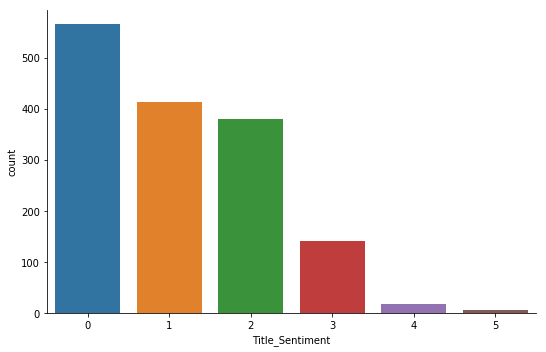

In [21]:
g = sns.catplot(x='polarityText',data=data, kind='count', aspect=1.5)
g = sns.catplot(x='sentimentText',data=data, kind='count', aspect=1.5)
g = sns.catplot(x='polaritySummary',data=data, kind='count', aspect=1.5)
g = sns.catplot(x='Title_Sentiment',data=readerData, kind='count', aspect=1.5)